In [34]:
import os
from typing import List, Dict, Tuple
import os
import ast

IGNORED_DIRS = {"__pycache__", ".git", ".venv", "venv", "env", ".env", "node_modules"}
IGNORED_FILES = {"__pycache__", "__init__.py"}

def extract_dependencies(file_path: str) -> Dict:
    """
    Extract all dependencies from a Python file based on import statements.
    
    Args:
        file_path: Path to the Python file
        
    Returns:
        Dictionary containing all dependencies
    """
    # Check if file exists
    if not os.path.exists(file_path):
        return {
            "error": f"File not found: {file_path}",
            "dependencies": []
        }
    
    # Read the file content
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
    except Exception as e:
        return {
            "error": f"Error reading file {file_path}: {str(e)}",
            "dependencies": []
        }
    
    # Parse the file using AST
    try:
        tree = ast.parse(content)
    except SyntaxError as e:
        return {
            "error": f"Syntax error in {file_path}: {str(e)}",
            "dependencies": []
        }
    
    # Extract dependencies
    dependencies = []
    
    for node in ast.walk(tree):
        # Handle 'import x' statements
        if isinstance(node, ast.Import):
            for name in node.names:
                module_name = name.name
                alias = name.asname
                
                dependencies.append({
                    "name": module_name,
                    "type": "import",
                    "alias": alias
                })
        
        # Handle 'from x import y' statements
        elif isinstance(node, ast.ImportFrom):
            module_name = node.module if node.module else ""
            level = node.level  # For relative imports (., .., etc.)
            
            dependency = {
                "name": module_name,
                "type": "from_import",
                "imports": []
            }
            
            # Add level for relative imports
            if level > 0:
                dependency["level"] = level
            
            for name in node.names:
                item_name = name.name
                alias = name.asname
                
                dependency["imports"].append({
                    "name": item_name,
                    "alias": alias
                })
            
            dependencies.append(dependency)
    
    return {
        "file": file_path,
        "dependencies": dependencies
    }



def discover_modules(root_dir: str) -> dict:
    """
    Recursively walk through the project root and map Python module names
    to their file paths, ignoring specified directories and files.
    
    Args:
        root_dir: Path to the top-level directory of your project.
    
    Returns:
        A dict where keys are module names (dotted paths) and values are file paths.
    """
    module_map = {}
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Modify dirnames in-place to skip ignored directories
        dirnames[:] = [d for d in dirnames if d not in IGNORED_DIRS]

        for filename in filenames:
            # Skip ignored files
            if filename in IGNORED_FILES or not filename.endswith('.py'):
                continue
            
            file_path = os.path.join(dirpath, filename)
            # Compute module name relative to root_dir
            rel_path = os.path.relpath(file_path, root_dir)
            mod_name = rel_path[:-3].replace(os.path.sep, '.')
            module_map[mod_name] = file_path

    return module_map


def resolve_file_dependencies(file_path: str, module_map: Dict[str, str], root_dir: str) -> List[str]:
    """
    Given a Python file, extract its internal dependencies and return
    the list of corresponding file paths within the project.

    Args:
        file_path: Path to the Python file to analyze.
        module_map: Mapping of module names to file paths (from discover_modules).
        root_dir: Path to the project root (to compute relative module name).

    Returns:
        A list of deduped file paths that this file depends on (internal to project).
    """
    deps_info = extract_dependencies(file_path)
    internal_files = []
    seen = set()

    # Compute current module name for resolving relative imports
    rel_curr = os.path.relpath(file_path, root_dir)[:-3].replace(os.path.sep, '.')
    
    for dep in deps_info["dependencies"]:
        # Determine the raw module string
        if dep["type"] == "import":
            mod_name = dep["name"]
        else:  # from_import
            level = dep.get("level", 0)
            base = dep["name"] or ""
            if level > 0:
                parts = rel_curr.split('.')[:-level]
                if base:
                    parts += base.split('.')
                mod_name = ".".join(parts)
            else:
                mod_name = base
        
        # If that module exists in our project, record its path (once)
        path = module_map.get(mod_name)
        if path and path not in seen:
            seen.add(path)
            internal_files.append(path)
    
    # Debug output
    print(f"\nFile: {file_path}")
    print(f"  Resolved internal modules: {len(internal_files)}")
    for p in internal_files:
        print(f"    - {p}")
    
    return internal_files

# Recursive driver to build full dependency graph
def build_dependency_graph(entry_file: str, module_map: Dict[str, str], root_dir: str) -> Dict[str, List[str]]:
    """
    Walks dependencies starting from entry_file, recursively resolving
    each file's internal dependencies to build the full graph.
    """
    graph = {}
    visited = set()

    def dfs(file_path: str):
        if file_path in visited:
            return
        visited.add(file_path)
        deps = resolve_file_dependencies(file_path, module_map, root_dir)
        graph[file_path] = deps
        for dep_path in deps:
            dfs(dep_path)

    dfs(entry_file)
    return graph


In [22]:
import json

def export_graph_to_json(graph: Dict[str, List[str]], root_dir: str, output_file: str = 'dependency_graph.json') -> None:
    """
    Export the dependency graph to a JSON file, using paths relative to the project root.
    
    Args:
        graph: Dependency graph mapping file paths to dependent file paths.
        root_dir: Project root directory for making paths relative.
        output_file: Name of the JSON file to write.
    """
    graph_rel = {}
    for file_path, deps in graph.items():
        # Convert absolute paths to paths relative to root
        rel_file = os.path.relpath(file_path, root_dir)
        # Convert each dependency path as well
        rel_deps = [os.path.relpath(dep, root_dir) for dep in deps]
        graph_rel[rel_file] = rel_deps

    # Write out JSON
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(graph_rel, f, indent=2)

    # Debug/confirmation output
    print(f"Exported dependency graph with {len(graph_rel)} nodes to {output_file}")


In [25]:
def extract_defined_functions(file_path: str) -> list:
    """
    Extract all top-level function names from a Python file using AST.

    Args:
        file_path: Path to the Python file.

    Returns:
        A list of function names defined in the file.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
    except Exception as e:
        print(f"Could not read {file_path}: {e}")
        return []
    
    try:
        tree = ast.parse(content)
    except SyntaxError as e:
        print(f"Syntax error in {file_path}: {e}")
        return []

    functions = []
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            # Collect the function name
            functions.append(node.name)
    return functions


In [35]:
def resolve_function_usages( file_path: str, module_map: Dict[str, str], root_dir: str, module_functions: Dict[str, List[str]]) -> List[Dict[str, str]]:
    """
    For a given Python file, find which functions from other modules are actually called.
    
    Args:
        file_path: Path to the Python file.
        module_map: Mapping of module names -> file paths.
        root_dir: Project root for relative resolution.
        module_functions: Mapping of module names -> list of defined function names.
    
    Returns:
        A list of dicts: { module: str, function: str, path: str } for each used function.
    """
    # Read and parse the file
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            tree = ast.parse(f.read())
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return []

    # Build import alias maps
    alias_map: Dict[str, str] = {}         # e.g. { 'tc': 'src.timeline_components' }
    direct_imports: Dict[str, Tuple[str, str]] = {}  # e.g. { 'initialize_session_state': ('src.timeline_components','initialize_session_state') }

    rel_curr = os.path.relpath(file_path, root_dir)[:-3].replace(os.path.sep, '.')

    for node in ast.walk(tree):
        if isinstance(node, ast.Import):
            for name in node.names:
                alias = name.asname or name.name.split('.')[0]
                alias_map[alias] = name.name  # full module path as imported

        elif isinstance(node, ast.ImportFrom):
            level = node.level
            base = node.module or ""
            # Resolve relative module if needed
            if level > 0:
                parts = rel_curr.split('.')[:-level]
                if base:
                    parts += base.split('.')
                base = ".".join(parts)
            for name in node.names:
                fn_alias = name.asname or name.name
                direct_imports[fn_alias] = (base, name.name)

    # Scan for function calls
    calls = set()
    for node in ast.walk(tree):
        if isinstance(node, ast.Call):
            func = node.func
            # Case: direct call to imported fn
            if isinstance(func, ast.Name) and func.id in direct_imports:
                calls.add(direct_imports[func.id])
            # Case: module.fn()
            elif isinstance(func, ast.Attribute) and isinstance(func.value, ast.Name):
                mod_alias = func.value.id
                if mod_alias in alias_map:
                    calls.add((alias_map[mod_alias], func.attr))

    # Map to project paths and drop any not in our definitions
    resolved = []
    for mod, fn in calls:
        if mod in module_map and fn in module_functions.get(mod, []):
            resolved.append({ "module": mod, "function": fn, "path": module_map[mod] })

    # Debug output
    print(f"\nFile: {file_path}")
    print("  Functions called:")
    for d in resolved:
        print(f"    - {d['module']}.{d['function']} ({d['path']})")
    return resolved


def build_function_dependency_graph(entry_file: str, module_map: Dict[str, str], root_dir: str, module_functions: Dict[str, List[str]]) -> Dict[str, List[Dict[str, str]]]:
    """
    Recursively walk from entry_file, resolving and recording actual function calls
    between modules.

    Returns:
        A dict mapping each file to a list of usage dicts:
        { "module": <module_name>, "function": <fn_name>, "path": <file_path> }
    """
    func_graph = {}
    visited = set()

    def dfs(file_path: str):
        if file_path in visited:
            return
        visited.add(file_path)

        # Find functions this file calls
        usages = resolve_function_usages(
            file_path, module_map, root_dir, module_functions
        )
        func_graph[file_path] = usages

        # Recurse into each called module
        for usage in usages:
            dfs(usage["path"])

    dfs(entry_file)
    return func_graph


---

In [13]:
# === Example Usage ===
root_dir = '.'  # adjust to your project root

modules = discover_modules(root_dir)  # from previous step

modules


{'run_tracker': './run_tracker.py',
 'docs.app_old': './docs/app_old.py',
 'src.app_components': './src/app_components.py',
 'src.gallery_view': './src/gallery_view.py',
 'src.data_io': './src/data_io.py',
 'src.utils': './src/utils.py',
 'src.timeline_component': './src/timeline_component.py',
 'src.calendar_view': './src/calendar_view.py',
 'src.app': './src/app.py',
 'src.login': './src/login.py',
 'src.app_draft': './src/app_draft.py',
 'src.ui_components': './src/ui_components.py',
 'src.utils.image_processor': './src/utils/image_processor.py',
 'src.utils.data_handler': './src/utils/data_handler.py',
 'src.utils.session_manager': './src/utils/session_manager.py',
 'src.api_services.vision': './src/api_services/vision.py',
 'src.api_services.weather': './src/api_services/weather.py'}

In [15]:
# === Example Usage ===
entry = os.path.join(root_dir, 'src/app.py')  # adjust to your entrypoint

dependency_graph = build_dependency_graph(entry, modules, root_dir)

# Inspect the graph
print("\nDependency Graph:")
for file, deps in dependency_graph.items():
    print(f"{file} ->")
    for d in deps:
        print(f"    {d}")


File: ./src/app.py
  Resolved internal modules: 2
    - ./src/timeline_component.py
    - ./src/app_components.py

File: ./src/timeline_component.py
  Resolved internal modules: 0

File: ./src/app_components.py
  Resolved internal modules: 3
    - ./src/timeline_component.py
    - ./src/utils/data_handler.py
    - ./src/utils/image_processor.py

File: ./src/utils/data_handler.py
  Resolved internal modules: 0

File: ./src/utils/image_processor.py
  Resolved internal modules: 0

Dependency Graph:
./src/app.py ->
    ./src/timeline_component.py
    ./src/app_components.py
./src/timeline_component.py ->
./src/app_components.py ->
    ./src/timeline_component.py
    ./src/utils/data_handler.py
    ./src/utils/image_processor.py
./src/utils/data_handler.py ->
./src/utils/image_processor.py ->


In [23]:
# === Example Usage ===
export_graph_to_json(dependency_graph, '.')


Exported dependency graph with 5 nodes to dependency_graph.json


In [ ]:
# === Step 2: Build a module->functions mapping ===
modules = discover_modules(root_dir)

module_functions = {}
for module_name, file_path in modules.items():
    funcs = extract_defined_functions(file_path)
    module_functions[module_name] = funcs
    
# === Step 3: Debug output ===
print("=== Defined Functions per Module (sample) ===")
for module_name, funcs in list(module_functions.items())[:10]:
    print(f"{module_name} -> {funcs}")
    print(' ')

In [42]:
# === Example Usage ===
# modules = discover_modules(root_dir)
# module_functions = {m: extract_defined_functions(p) for m,p in modules.items()}

# Build and inspect the function-level graph
entry_file = os.path.join(root_dir, 'src/app.py')  # adjust to an entry file
func_dep_graph = build_function_dependency_graph(entry_file, modules, root_dir, module_functions)



File: ./src/app.py
  Functions called:
    - src.timeline_component.render_timeline (./src/timeline_component.py)
    - src.app_components.display_inspection_metadata (./src/app_components.py)
    - src.app_components.render_sidebar (./src/app_components.py)
    - src.app_components.display_image_and_photo_metadata (./src/app_components.py)
    - src.app_components.display_photo_analysis (./src/app_components.py)
    - src.timeline_component.initialize_session_state (./src/timeline_component.py)

File: ./src/timeline_component.py
  Functions called:

File: ./src/app_components.py
  Functions called:
    - src.utils.data_handler.add_photo_to_inspection (./src/utils/data_handler.py)
    - src.utils.image_processor.process_url_image (./src/utils/image_processor.py)

File: ./src/utils/data_handler.py
  Functions called:

File: ./src/utils/image_processor.py
  Functions called:


---

In [54]:
from pyvis.network import Network
import os

# === Configuration ===
# Paths to entry scripts relative to project root
entry_points = [
    "src/app.py",
    "src/timeline_component.py",
    "src/app_components.py",
    "src/gallery_view.py",
    "src/calendar_view.py"
]

# Compute module names for entries
entry_modules = [
    ep[:-3].replace(os.path.sep, ".") for ep in entry_points
]

# Initialize PyVis network
net = Network(notebook=True, height="750px", width="100%")

# 1. Add module nodes (star for entries, box for others)
for module, funcs in module_functions.items():
    shape = "star" if module in entry_modules else "box"
    color = "gold" if module in entry_modules else "skyblue"
    title = (f"Entry Script: {module}" if module in entry_modules 
             else f"Module: {module}")
    net.add_node(module, label=module, shape=shape, color=color, title=title)

# 2. Add function-definition nodes and dashed "defines" edges
for module, funcs in module_functions.items():
    for fn in funcs:
        fn_node = f"{module}.{fn}"
        net.add_node(
            fn_node,
            label=fn,
            shape="ellipse",
            color="lightgreen",
            title=f"Function {fn} defined in {module}"
        )
        net.add_edge(module, fn_node, dash=True, title="defines")

# 3. Add solid "calls" edges by aggregating each entry's function dependency graph
for ep in entry_points:
    entry_path = os.path.join(root_dir, ep)
    fgraph = build_function_dependency_graph(
        entry_path, modules, root_dir, module_functions
    )
    for caller_path, usages in fgraph.items():
        caller_mod = os.path.relpath(caller_path, root_dir)[:-3].replace(os.path.sep, ".")
        for u in usages:
            fn_node = f"{u['module']}.{u['function']}"
            net.add_edge(caller_mod, fn_node, dash=False, title="calls")

# 4. Render interactive graph
net.show("function_dependency_graph.html")



File: ./src/app.py
  Functions called:
    - src.timeline_component.render_timeline (./src/timeline_component.py)
    - src.app_components.display_inspection_metadata (./src/app_components.py)
    - src.app_components.render_sidebar (./src/app_components.py)
    - src.app_components.display_image_and_photo_metadata (./src/app_components.py)
    - src.app_components.display_photo_analysis (./src/app_components.py)
    - src.timeline_component.initialize_session_state (./src/timeline_component.py)

File: ./src/timeline_component.py
  Functions called:

File: ./src/app_components.py
  Functions called:
    - src.utils.data_handler.add_photo_to_inspection (./src/utils/data_handler.py)
    - src.utils.image_processor.process_url_image (./src/utils/image_processor.py)

File: ./src/utils/data_handler.py
  Functions called:

File: ./src/utils/image_processor.py
  Functions called:

File: ./src/timeline_component.py
  Functions called:

File: ./src/app_components.py
  Functions called:
    - s

In [58]:
from pyvis.network import Network
from IPython.core.display import HTML, display
import os

# === Notebook Title ===
display(HTML("<h2>Function-Level Dependency Graph</h2>"))

# === Configuration ===
entry_points = [
    "run_tracker.py",
    "src/app.py",
    "src/timeline_component.py",
    "src/app_components.py",
    "src/gallery_view.py",
    "src/calendar_view.py"
]
entry_modules = [ep[:-3].replace(os.path.sep, ".") for ep in entry_points]

# Initialize PyVis network
net = Network(height="750px", width="100%", notebook=True, cdn_resources='in_line')

# 1. Add module and function nodes
for module, funcs in module_functions.items():
    # Module node
    node_shape = "star" if module in entry_modules else "box"
    node_color = "gold" if module in entry_modules else "skyblue"
    net.add_node(module, label=module, shape=node_shape, color=node_color)

    # Function-definition nodes
    for fn in funcs:
        fn_node = f"{module}.{fn}"
        net.add_node(fn_node, label=fn, shape="ellipse", color="lightgreen")

# 2. Defines edges (function → module)
for module, funcs in module_functions.items():
    for fn in funcs:
        fn_node = f"{module}.{fn}"
        net.add_edge(
            fn_node,
            module,
            title="defines",
            color="gray",
            width=2,
            arrows="to",
            dash=False
        )

# 3. Calls edges (function → importing module)
for ep in entry_points:
    entry_path = os.path.join(root_dir, ep)
    fgraph = build_function_dependency_graph(entry_path, modules, root_dir, module_functions)
    for caller_path, usages in fgraph.items():
        caller_mod = os.path.relpath(caller_path, root_dir)[:-3].replace(os.path.sep, ".")
        for u in usages:
            fn_node = f"{u['module']}.{u['function']}"
            net.add_edge(
                fn_node,
                caller_mod,
                title="calls",
                color="yellow",
                width=4,
                arrows="to",
                dash=True
            )

# 4. Render interactive graph with title
net.show("function_dependency_graph.html")


/var/folders/n5/186jc66x5_b_6gqsc81243cr0000gn/T/ipykernel_39763/2099991072.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display



File: ./run_tracker.py
  Functions called:

File: ./src/app.py
  Functions called:
    - src.timeline_component.render_timeline (./src/timeline_component.py)
    - src.app_components.display_inspection_metadata (./src/app_components.py)
    - src.app_components.render_sidebar (./src/app_components.py)
    - src.app_components.display_image_and_photo_metadata (./src/app_components.py)
    - src.app_components.display_photo_analysis (./src/app_components.py)
    - src.timeline_component.initialize_session_state (./src/timeline_component.py)

File: ./src/timeline_component.py
  Functions called:

File: ./src/app_components.py
  Functions called:
    - src.utils.data_handler.add_photo_to_inspection (./src/utils/data_handler.py)
    - src.utils.image_processor.process_url_image (./src/utils/image_processor.py)

File: ./src/utils/data_handler.py
  Functions called:

File: ./src/utils/image_processor.py
  Functions called:

File: ./src/timeline_component.py
  Functions called:

File: ./src/a

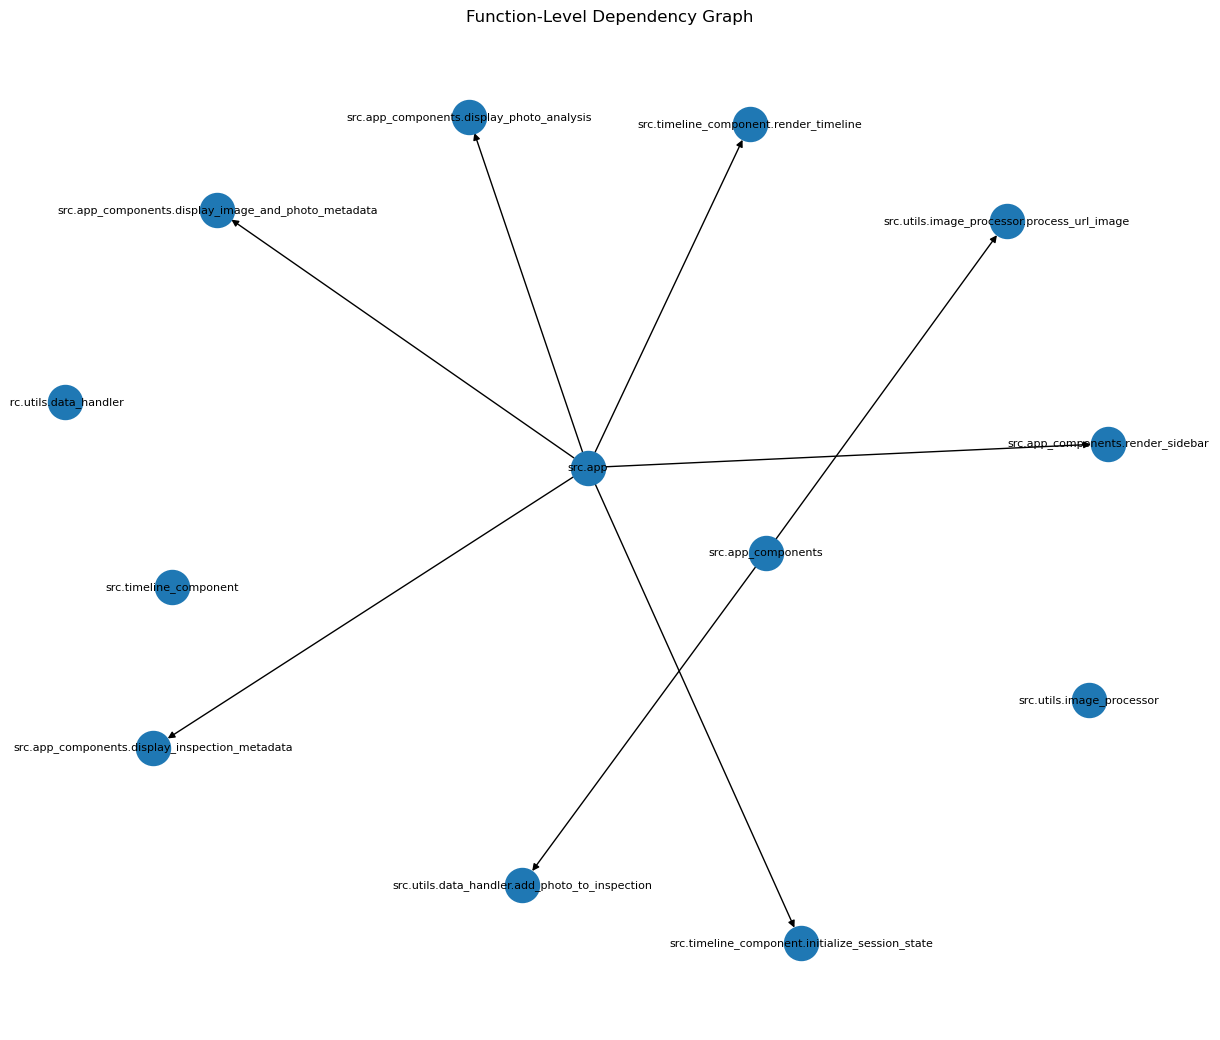

In [47]:
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network


G = nx.DiGraph()
for caller_path, usages in func_dep_graph.items():
    caller_module = os.path.relpath(caller_path, root_dir)[:-3].replace(os.path.sep, '.')
    G.add_node(caller_module)
    for u in usages:
        callee = f"{u['module']}.{u['function']}"
        G.add_node(callee)
        G.add_edge(caller_module, callee)

plt.figure(figsize=(12,10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=600, font_size=8)
plt.title("Function-Level Dependency Graph")
plt.show()


In [51]:
net = Network(height="750px", width="100%", notebook=True, cdn_resources='in_line')

# 1. Module → Defined Functions (dashed edges)
for module, funcs in module_functions.items():
    net.add_node(
        module,
        label=module,
        shape='box',
        color='skyblue',
        title=f"Module: {module}"
    )
    for fn in funcs:
        fn_node = f"{module}.{fn}"
        net.add_node(
            fn_node,
            label=fn,
            shape='ellipse',
            color='lightgreen',
            title=f"Function {fn} defined in {module}"
        )
        net.add_edge(
            module,
            fn_node,
            dash=True,
            title="defines"
        )

# 2. Module → Called Functions (solid edges)
for caller_path, usages in func_dep_graph.items():
    caller_module = os.path.relpath(caller_path, root_dir)[:-3].replace(os.path.sep, '.')
    for u in usages:
        fn_node = f"{u['module']}.{u['function']}"
        net.add_edge(
            caller_module,
            fn_node,
            dash=False,
            title="calls"
        )

# 3. Render interactive graph
net.show("function_dependency_graph.html")


function_dependency_graph.html


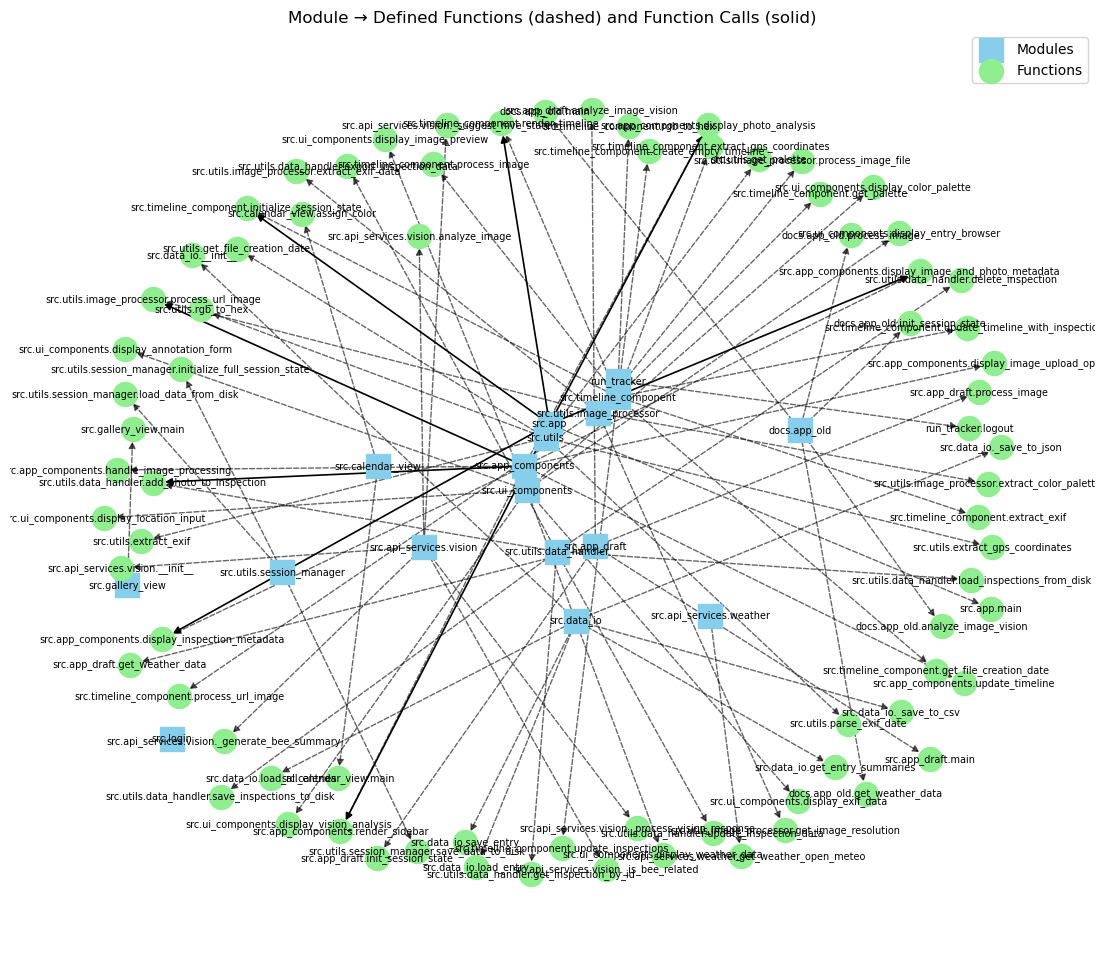

In [50]:
# from pyvis.network import Network
# import os

# net = Network(height="750px", width="100%", notebook=True, cdn_resources='in_line')

# Build a combined module-function graph
G = nx.DiGraph()

# 1. Add module and function-definition edges
for module, funcs in module_functions.items():
    # Module node
    G.add_node(module, type='module')
    # Add function nodes and "defines" edges
    for fn in funcs:
        fn_node = f"{module}.{fn}"
        G.add_node(fn_node, type='function')
        G.add_edge(module, fn_node, link_type='defines')

# 2. Add usage edges (calls)
for caller_path, usages in func_dep_graph.items():
    caller_mod = os.path.relpath(caller_path, root_dir)[:-3].replace(os.path.sep, '.')
    for u in usages:
        fn_node = f"{u['module']}.{u['function']}"
        # Keep existing defines edges and add calls
        G.add_edge(caller_mod, fn_node, link_type='calls')

# 3. Visualize with NetworkX + Matplotlib
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Separate node types
module_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'module']
function_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'function']

# Draw nodes
nx.draw_networkx_nodes(G, pos,
                       nodelist=module_nodes,
                       node_shape='s',
                       node_color='skyblue',
                       label='Modules')
nx.draw_networkx_nodes(G, pos,
                       nodelist=function_nodes,
                       node_shape='o',
                       node_color='lightgreen',
                       label='Functions')

# Draw edges by type
defines_edges = [(u, v) for u, v, d in G.edges(data=True) if d['link_type'] == 'defines']
calls_edges = [(u, v) for u, v, d in G.edges(data=True) if d['link_type'] == 'calls']

nx.draw_networkx_edges(G, pos, edgelist=defines_edges, style='dashed', alpha=0.6)
nx.draw_networkx_edges(G, pos, edgelist=calls_edges, style='solid', width=1.2, edge_color='black')

# Labels
nx.draw_networkx_labels(G, pos, font_size=7)

plt.title("Module → Defined Functions (dashed) and Function Calls (solid)")
plt.axis('off')
plt.legend(scatterpoints=1)
plt.show()


In [ ]:
#!/usr/bin/env python3
"""
Python Project Dependency Mapper

This script analyzes Python project dependencies, starting from an entry point file,
and creates a visual representation of all internal and external dependencies.
It also identifies orphaned scripts (unused Python files in the project).

Usage:
    python dependency_mapper.py --entry-point app.py --project-dir ./my_project --show-orphans

Outputs:
    1. A JSON file containing all dependency relationships suitable for Neo4j import
    2. A visual network graph (HTML) showing the relationships between files and imports

Date: April 29, 2025


## What This Notebook Does
The notebook contains all the core functionality needed to analyze Python project dependencies but in a more interactive format that lets you:  
- Test incrementally: Run each step separately to verify it works correctly
- Visualize immediately: See the dependency graph directly in the notebook
- Experiment easily: Modify parameters and re-run cells to test different scenarios  

"""


In [ ]:
IGNORED_DIRS = {"__pycache__", ".git", ".venv", "venv", "env", ".env", "node_modules"}
IGNORED_FILES = {"__pycache__", "__init__.py"}

# Set your project directory and entry point
project_dir = "."
entry_point = "./src/app.py"

# Map dependencies
dep_map = map_dependencies(entry_point, project_dir)

# Print summary
print(f"Total Python files: {len(dep_map['all_files'])}")
print(f"Processed files: {len(dep_map['dependencies']['processed'])}")
print(f"Orphaned files: {len(dep_map['orphaned'])}")

# List orphaned files
print("\nOrphaned files:")
for file in dep_map['orphaned']:
    print(f"  - {os.path.basename(file)}")



In [ ]:
# # Example usage
# file_path = "./src/app.py"
# dependencies = extract_dependencies(file_path)

# # Print formatted dependencies
# print(format_dependencies(dependencies))

# # Or access the raw data
# for dep in dependencies["dependencies"]:
#     print(dep)

In [ ]:
# Example usage
file_path = "./src/app_components.py"
dependencies_ac = extract_dependencies(file_path)

# # Print formatted dependencies
# print(format_dependencies(dependencies))

# Or access the raw data
for dep in dependencies_ac["dependencies"]:
    print(dep)

In [ ]:
dependencies_ac["dependencies"]

In [ ]:
# import os
# import sys
# import ast
# import json
# import importlib
# import pkgutil
# from pathlib import Path
# from typing import Dict, List, Set, Tuple, Optional, Any
# import argparse
# import re

# # For visualization
# from pyvis.network import Network
# import networkx as nx

# # For notebook testing
# import matplotlib.pyplot as plt
# from IPython.display import display, HTML, IFrame

# # Constants
# IGNORED_DIRS = {"__pycache__", ".git", ".venv", "venv", "env", ".env", "node_modules"}
# IGNORED_FILES = {"__pycache__"}
# STANDARD_LIBS = set(sys.stdlib_modules) if hasattr(sys, 'stdlib_modules') else {
#     m.name for m in pkgutil.iter_modules()
#     if not m.name.startswith('_') and not '.' in m.name
# }

# # Node types and colors
# NODE_TYPES = {
#     "entry_point": {"color": "#FF5733", "size": 25},  # Orange for entry point
#     "internal_module": {"color": "#33A8FF", "size": 20},  # Blue for internal modules
#     "internal_function": {"color": "#33FFA8", "size": 15},  # Light green for internal functions
#     "external_dependency": {"color": "#A833FF", "size": 15},  # Purple for external dependencies
#     "unused_module": {"color": "#AAAAAA", "size": 15},  # Gray for unused modules
# }

# class DependencyMapper:
#     """
#     Analyzes and visualizes Python project dependencies.
#     """
    
#     def __init__(self, entry_point: str, project_root: Path = None):
#         """
#         Initialize the dependency mapper with the specified entry point.
        
#         Args:
#             entry_point: Path to the entry point Python file
#             project_root: Root directory of the project (default: current directory)
#         """
#         self.entry_point = Path(entry_point).resolve()
        
#         # If project root not specified, use current directory
#         if project_root is None:
#             self.project_root = Path.cwd()
#         else:
#             self.project_root = Path(project_root).resolve()
            
#         # Ensure entry point exists
#         if not self.entry_point.exists():
#             raise FileNotFoundError(f"Entry point not found: {self.entry_point}")
            
#         # Initialize data structures
#         self.dependency_graph = nx.DiGraph()
#         self.module_to_path = {}  # Maps module names to file paths
#         self.path_to_module = {}  # Maps file paths to module names
#         self.analyzed_files = set()  # Keep track of files we've analyzed
#         self.internal_modules = set()  # Set of modules internal to the project
#         self.external_modules = set()  # Set of external modules
#         self.function_to_module = {}  # Maps functions to their containing modules
#         self.requirements = self._parse_requirements()  # Parse requirements.txt

#     def display_in_notebook(self, height=800, width=1000):
#         """
#         Display the dependency graph directly in the Jupyter notebook.

#         Args:
#             height: Height of the visualization in pixels
#             width: Width of the visualization in pixels
#         """
#         # Create a temporary file for the visualization
#         temp_file = "temp_dependency_map.html"
#         self.generate_visualization(temp_file)

#         # Display the visualization in the notebook
#         display(IFrame(temp_file, width=width, height=height))

#         # Also display some statistics
#         print(f"Analysis summary:")
#         print(f"- Entry point: {self.entry_point}")
#         print(f"- {len(self.internal_modules)} internal modules found")
#         print(f"- {len(self.external_modules)} external dependencies found")

#         # Display top dependencies
#         if self.external_modules:
#             print("\nExternal dependencies:")
#             for dep in sorted(self.external_modules):
#                 version = self.requirements.get(dep, "unknown version")
#                 print(f"- {dep}: {version}")

#         # Display unused modules
#         unused = self.find_unused_modules()
#         if unused:
#             print(f"\nUnused modules ({len(unused)}):")
#             for mod in sorted(unused):
#                 if mod in self.module_to_path:
#                     print(f"- {mod} ({self.module_to_path[mod]})")
#                 else:
#                     print(f"- {mod}")

#     def plot_dependency_graph(self, figsize=(12, 10)):
#         """
#         Plot the dependency graph using matplotlib for a static view.
#         This is useful for a quick preview before generating the interactive HTML.

#         Args:
#             figsize: Size of the figure (width, height) in inches
#         """
#         # Create positions using a layout algorithm
#         pos = nx.spring_layout(self.dependency_graph, k=0.15, iterations=50)

#         # Create a new figure
#         plt.figure(figsize=figsize)

#         # Plot different node types with different colors
#         node_types = nx.get_node_attributes(self.dependency_graph, 'type')

#         # Group nodes by type
#         node_groups = {}
#         for node, node_type in node_types.items():
#             node_groups.setdefault(node_type, []).append(node)

#         # Plot each group
#         for node_type, nodes in node_groups.items():
#             style = NODE_TYPES.get(node_type, {"color": "#CCCCCC", "size": 10})
#             nx.draw_networkx_nodes(
#                 self.dependency_graph,
#                 pos,
#                 nodelist=nodes,
#                 node_color=style["color"],
#                 node_size=style["size"]*10,
#                 alpha=0.8,
#                 label=node_type
#             )

#         # Plot edges
#         nx.draw_networkx_edges(
#             self.dependency_graph,
#             pos,
#             alpha=0.5,
#             arrows=True,
#             arrowsize=15
#         )

#         # Plot labels for important nodes
#         # Only label modules (not functions) to avoid clutter
#         labels = {
#             node: node.split(".")[-1] 
#             for node, attrs in self.dependency_graph.nodes(data=True)
#             if attrs.get("is_module", False)
#         }
#         nx.draw_networkx_labels(
#             self.dependency_graph,
#             pos,
#             labels=labels,
#             font_size=8
#         )

#         plt.title("Project Dependency Graph")
#         plt.legend()
#         plt.axis("off")
#         plt.tight_layout()
#         plt.show()

        
#     def _parse_requirements(self) -> Dict[str, str]:
#         """Parse requirements.txt to get package versions."""
#         requirements = {}
#         req_file = self.project_root / "requirements.txt"
        
#         if req_file.exists():
#             with open(req_file, "r") as f:
#                 for line in f:
#                     line = line.strip()
#                     if line and not line.startswith("#"):
#                         # Handle different requirement formats
#                         if "==" in line:
#                             package, version = line.split("==", 1)
#                             requirements[package.strip()] = version.strip()
#                         elif ">=" in line:
#                             package, version = line.split(">=", 1)
#                             requirements[package.strip()] = f">={version.strip()}"
#                         else:
#                             # Just store the package name
#                             requirements[line.strip()] = ""
        
#         return requirements
    
#     def _is_internal_path(self, path: Path) -> bool:
#         """
#         Check if a path is internal to the project.
        
#         Args:
#             path: Path to check
            
#         Returns:
#             bool: True if the path is within the project, False otherwise
#         """
#         try:
#             # Check if the path is a subdirectory of the project root
#             return self.project_root in path.resolve().parents
#         except (ValueError, OSError):
#             # Handle invalid paths
#             return False
    
#     def _get_module_name(self, file_path: Path) -> str:
#         """
#         Convert a file path to a module name.
        
#         Args:
#             file_path: Path to the Python file
            
#         Returns:
#             str: Module name corresponding to the file path
#         """
#         if file_path in self.path_to_module:
#             return self.path_to_module[file_path]
            
#         # Get the relative path from the project root
#         try:
#             rel_path = file_path.relative_to(self.project_root)
#         except ValueError:
#             # File is outside the project root
#             return file_path.stem
            
#         # Convert path to module name
#         parts = list(rel_path.parts)
#         if parts[-1] == "__init__.py":
#             # If it's an __init__.py file, use the directory name
#             parts.pop()
#         else:
#             # Otherwise, replace the .py extension with nothing
#             parts[-1] = Path(parts[-1]).stem
            
#         module_name = ".".join(parts)
        
#         # Cache the result
#         self.path_to_module[file_path] = module_name
#         self.module_to_path[module_name] = file_path
        
#         return module_name
    
#     def _resolve_import(self, module_name: str, current_dir: Path) -> Optional[Path]:
#         """
#         Resolve an import statement to a file path.
        
#         Args:
#             module_name: The name of the module to import
#             current_dir: The directory from which the import is made
            
#         Returns:
#             Optional[Path]: The path to the imported module, or None if not found
#         """
#         # Check if it's a standard library module
#         if module_name.split(".")[0] in STANDARD_LIBS:
#             return None
            
#         # Check for relative imports
#         if module_name.startswith("."):
#             # Count the number of dots for relative imports
#             dot_count = 0
#             for char in module_name:
#                 if char == ".":
#                     dot_count += 1
#                 else:
#                     break
                    
#             # Get the package part of the current module
#             parent_dir = current_dir
#             for _ in range(dot_count-1):
#                 parent_dir = parent_dir.parent
                
#             # Get the module name without the dots
#             rel_module = module_name[dot_count:]
#             if rel_module:
#                 # Try to find the module
#                 parts = rel_module.split(".")
#                 module_path = parent_dir.joinpath(*parts)
                
#                 # Check if it's a directory with __init__.py
#                 if module_path.is_dir() and (module_path / "__init__.py").exists():
#                     return (module_path / "__init__.py").resolve()
                    
#                 # Check if it's a .py file
#                 py_path = Path(f"{module_path}.py")
#                 if py_path.exists():
#                     return py_path.resolve()
#             else:
#                 # Just dots means the current package
#                 init_path = parent_dir / "__init__.py"
#                 if init_path.exists():
#                     return init_path.resolve()
#         else:
#             # Absolute import
#             # First check if it's in the module cache
#             if module_name in self.module_to_path:
#                 return self.module_to_path[module_name]
                
#             # Try to find the module in the project
#             parts = module_name.split(".")
            
#             # Try as a top-level import
#             for i in range(len(parts), 0, -1):
#                 prefix = parts[:i]
#                 suffix = parts[i:]
                
#                 # Check if this prefix is a valid module
#                 prefix_path = self.project_root.joinpath(*prefix)
                
#                 # If it's a directory with __init__.py
#                 if prefix_path.is_dir() and (prefix_path / "__init__.py").exists():
#                     # If there are suffix parts, continue resolving
#                     if suffix:
#                         suffix_path = prefix_path.joinpath(*suffix)
                        
#                         # Check for directory with __init__.py
#                         if suffix_path.is_dir() and (suffix_path / "__init__.py").exists():
#                             return (suffix_path / "__init__.py").resolve()
                            
#                         # Check for .py file
#                         py_path = Path(f"{suffix_path}.py")
#                         if py_path.exists():
#                             return py_path.resolve()
#                     else:
#                         # No suffix parts, just return the __init__.py
#                         return (prefix_path / "__init__.py").resolve()
                
#                 # If it's a .py file
#                 py_path = Path(f"{prefix_path}.py")
#                 if py_path.exists():
#                     # If there are suffix parts, they are attributes/functions
#                     # We don't resolve those to files
#                     if not suffix:
#                         return py_path.resolve()
        
#         # If we got here, it's likely an external dependency
#         return None
    
#     def _parse_imports(self, file_path: Path) -> Tuple[List[str], Dict[str, List[str]]]:
#         """
#         Parse import statements from a Python file.
        
#         Args:
#             file_path: Path to the Python file
            
#         Returns:
#             Tuple containing:
#             - List of imported modules
#             - Dictionary mapping modules to imported names
#         """
#         with open(file_path, "r", encoding="utf-8") as f:
#             try:
#                 tree = ast.parse(f.read(), filename=str(file_path))
#             except SyntaxError:
#                 print(f"Syntax error in {file_path}. Skipping.", file=sys.stderr)
#                 return [], {}
        
#         imports = []
#         import_from = {}
        
#         for node in ast.walk(tree):
#             if isinstance(node, ast.Import):
#                 # Handle regular imports: import os, sys
#                 for name in node.names:
#                     imports.append(name.name)
#             elif isinstance(node, ast.ImportFrom):
#                 # Handle from imports: from os import path
#                 if node.module is not None:
#                     # Construct full module name for relative imports
#                     full_module = "." * node.level + (node.module or "")
                    
#                     # Store imported names
#                     imported_names = [alias.name for alias in node.names]
#                     import_from.setdefault(full_module, []).extend(imported_names)
        
#         return imports, import_from
    
#     def _extract_functions(self, file_path: Path) -> List[str]:
#         """
#         Extract function definitions from a Python file.
        
#         Args:
#             file_path: Path to the Python file
            
#         Returns:
#             List of function names defined in the file
#         """
#         with open(file_path, "r", encoding="utf-8") as f:
#             try:
#                 tree = ast.parse(f.read(), filename=str(file_path))
#             except SyntaxError:
#                 print(f"Syntax error in {file_path}. Skipping.", file=sys.stderr)
#                 return []
        
#         functions = []
        
#         # Get top-level function definitions
#         for node in ast.iter_child_nodes(tree):
#             if isinstance(node, ast.FunctionDef):
#                 functions.append(node.name)
                
#             # Also check class methods
#             elif isinstance(node, ast.ClassDef):
#                 for child in ast.iter_child_nodes(node):
#                     if isinstance(child, ast.FunctionDef):
#                         # Include class methods as ClassName.method_name
#                         functions.append(f"{node.name}.{child.name}")
        
#         return functions
    
#     def analyze_file(self, file_path: Path, parent_module: Optional[str] = None) -> None:
#         """
#         Analyze imports and dependencies in a Python file.
        
#         Args:
#             file_path: Path to the Python file
#             parent_module: Name of the module that imported this file
#         """
#         # Skip if already analyzed
#         if file_path in self.analyzed_files:
#             return
            
#         self.analyzed_files.add(file_path)
        
#         # Get the module name for this file
#         module_name = self._get_module_name(file_path)
        
#         # Add the module to the graph
#         if file_path == self.entry_point:
#             node_type = "entry_point"
#         else:
#             node_type = "internal_module"
#             self.internal_modules.add(module_name)
            
#         self.dependency_graph.add_node(
#             module_name,
#             type=node_type,
#             path=str(file_path),
#             is_module=True
#         )
        
#         # If this file was imported by another, add the edge
#         if parent_module:
#             self.dependency_graph.add_edge(
#                 parent_module,
#                 module_name,
#                 type="import"
#             )
        
#         # Extract functions defined in this file
#         functions = self._extract_functions(file_path)
#         for func_name in functions:
#             # Create a unique ID for the function
#             func_id = f"{module_name}.{func_name}"
            
#             # Add the function to the graph
#             self.dependency_graph.add_node(
#                 func_id,
#                 type="internal_function",
#                 name=func_name,
#                 is_module=False
#             )
            
#             # Connect the function to its module
#             self.dependency_graph.add_edge(
#                 module_name,
#                 func_id,
#                 type="defines"
#             )
            
#             # Track which module contains this function
#             self.function_to_module[func_id] = module_name
        
#         # Parse imports
#         imports, import_from = self._parse_imports(file_path)
        
#         # Process regular imports
#         for imp in imports:
#             # Try to resolve the import to a file path
#             imp_path = self._resolve_import(imp, file_path.parent)
            
#             if imp_path:
#                 # It's an internal module
#                 imp_module = self._get_module_name(imp_path)
                
#                 # Add edge for the import
#                 self.dependency_graph.add_edge(
#                     module_name,
#                     imp_module,
#                     type="import",
#                     statement=f"import {imp}"
#                 )
                
#                 # Recursively analyze the imported file
#                 self.analyze_file(imp_path, module_name)
#             else:
#                 # It's an external module
#                 # Add to external dependencies
#                 top_level = imp.split(".")[0]
#                 self.external_modules.add(top_level)
                
#                 # Add to the graph
#                 self.dependency_graph.add_node(
#                     imp,
#                     type="external_dependency",
#                     is_module=True
#                 )
                
#                 # Add edge for the import
#                 self.dependency_graph.add_edge(
#                     module_name,
#                     imp,
#                     type="import",
#                     statement=f"import {imp}"
#                 )
        
#         # Process from imports
#         for module, names in import_from.items():
#             # Try to resolve the import to a file path
#             module_path = self._resolve_import(module, file_path.parent)
            
#             if module_path:
#                 # It's an internal module
#                 from_module = self._get_module_name(module_path)
                
#                 # Add edge for the import
#                 from_statement = f"from {module} import {', '.join(names)}"
#                 self.dependency_graph.add_edge(
#                     module_name,
#                     from_module,
#                     type="import_from",
#                     statement=from_statement,
#                     imported_names=names
#                 )
                
#                 # For each imported name, check if it's a function
#                 module_functions = self._extract_functions(module_path)
#                 for name in names:
#                     # If it's a function in the module, add a direct edge to it
#                     if name in module_functions:
#                         func_id = f"{from_module}.{name}"
                        
#                         # Add edge from the importing module to the function
#                         self.dependency_graph.add_edge(
#                             module_name,
#                             func_id,
#                             type="imports_function",
#                             statement=f"from {module} import {name}"
#                         )
                
#                 # Recursively analyze the imported file
#                 self.analyze_file(module_path, module_name)
#             else:
#                 # It's an external module
#                 # Add to external dependencies
#                 top_level = module.split(".")[0].lstrip(".")
#                 if top_level:  # Ensure it's not an empty string
#                     self.external_modules.add(top_level)
                
#                     # Add to the graph
#                     self.dependency_graph.add_node(
#                         module,
#                         type="external_dependency",
#                         is_module=True
#                     )
                    
#                     # Add edge for the import
#                     from_statement = f"from {module} import {', '.join(names)}"
#                     self.dependency_graph.add_edge(
#                         module_name,
#                         module,
#                         type="import_from",
#                         statement=from_statement,
#                         imported_names=names
#                     )
    
#     def find_unused_modules(self) -> Set[str]:
#         """
#         Find Python modules in the project that are not part of the dependency tree.
        
#         Returns:
#             Set of module names that are not used by the entry point
#         """
#         # Find all Python files in the project
#         all_modules = set()
#         for path in self.project_root.glob("**/*.py"):
#             # Skip files in ignored directories
#             if any(ignored in path.parts for ignored in IGNORED_DIRS):
#                 continue
                
#             # Get the module name
#             module_name = self._get_module_name(path)
#             all_modules.add(module_name)
        
#         # Get modules that are in the dependency graph
#         used_modules = {
#             node for node, attrs in self.dependency_graph.nodes(data=True)
#             if attrs.get("is_module", False) and attrs.get("type") != "external_dependency"
#         }
        
#         # Return the difference
#         return all_modules - used_modules
    
#     def analyze(self) -> None:
#         """
#         Analyze the project starting from the entry point.
#         """
#         # Start the analysis from the entry point
#         self.analyze_file(self.entry_point)
        
#         # Find unused modules
#         unused_modules = self.find_unused_modules()
        
#         # Add unused modules to the graph
#         for module in unused_modules:
#             if module in self.module_to_path:
#                 path = self.module_to_path[module]
                
#                 self.dependency_graph.add_node(
#                     module,
#                     type="unused_module",
#                     path=str(path),
#                     is_module=True
#                 )
    
#     def generate_json(self) -> Dict[str, Any]:
#         """
#         Generate a JSON representation of the dependency graph.
        
#         Returns:
#             Dict containing the dependency information
#         """
#         data = {
#             "entry_point": str(self.entry_point),
#             "project_root": str(self.project_root),
#             "nodes": [],
#             "edges": [],
#             "requirements": self.requirements
#         }
        
#         # Add nodes
#         for node, attrs in self.dependency_graph.nodes(data=True):
#             node_data = {
#                 "id": node,
#                 "type": attrs.get("type", "unknown"),
#                 "is_module": attrs.get("is_module", False)
#             }
            
#             # Add optional attributes
#             if "path" in attrs:
#                 node_data["path"] = attrs["path"]
#             if "name" in attrs:
#                 node_data["name"] = attrs["name"]
                
#             data["nodes"].append(node_data)
        
#         # Add edges
#         for source, target, attrs in self.dependency_graph.edges(data=True):
#             edge_data = {
#                 "source": source,
#                 "target": target,
#                 "type": attrs.get("type", "unknown")
#             }
            
#             # Add optional attributes
#             if "statement" in attrs:
#                 edge_data["statement"] = attrs["statement"]
#             if "imported_names" in attrs:
#                 edge_data["imported_names"] = attrs["imported_names"]
                
#             data["edges"].append(edge_data)
            
#         return data
    
#     def generate_visualization(self, output_file: str = "dependency_map.html") -> None:
#         """
#         Generate an interactive visualization of the dependency graph.
        
#         Args:
#             output_file: Path to save the HTML visualization
#         """
#         # Create a Pyvis network
#         net = Network(height="800px", width="100%", directed=True, notebook=False)
        
#         # Add nodes
#         for node, attrs in self.dependency_graph.nodes(data=True):
#             node_type = attrs.get("type", "unknown")
            
#             # Get style for this node type
#             style = NODE_TYPES.get(node_type, {"color": "#CCCCCC", "size": 10})
            
#             # Create label based on node type
#             if node_type == "internal_function":
#                 label = attrs.get("name", node.split(".")[-1])
#             else:
#                 label = node.split(".")[-1]  # Use the last part of the module name
                
#             # Add the node
#             net.add_node(
#                 node,
#                 label=label,
#                 title=node,  # Tooltip shows full name
#                 color=style["color"],
#                 size=style["size"]
#             )
        
#         # Add edges
#         for source, target, attrs in self.dependency_graph.edges(data=True):
#             edge_type = attrs.get("type", "unknown")
            
#             # Set edge color based on type
#             if edge_type in ["import", "import_from"]:
#                 color = "#007700"  # Green for imports
#             elif edge_type == "imports_function":
#                 color = "#0000FF"  # Blue for function imports
#             elif edge_type == "defines":
#                 color = "#770000"  # Red for definitions
#             else:
#                 color = "#000000"  # Black for other edges
                
#             # Create label
#             if "statement" in attrs:
#                 label = attrs["statement"]
#             else:
#                 label = edge_type
                
#             # Add the edge
#             net.add_edge(
#                 source,
#                 target,
#                 title=label,  # Tooltip shows import statement
#                 color=color
#             )
        
#         # Configure physics for better layout
#         net.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=200)
        
#         # Save to HTML file
#         net.show(output_file)
#         print(f"Visualization saved to {output_file}")
        
#     def save_json(self, output_file: str = "dependency_map.json") -> None:
#         """
#         Save the dependency information as a JSON file.
        
#         Args:
#             output_file: Path to save the JSON file
#         """
#         data = self.generate_json()
        
#         with open(output_file, "w") as f:
#             json.dump(data, f, indent=2)
            
#         print(f"Dependency data saved to {output_file}")




In [ ]:
# # Create a mapper instance with your entry point
# mapper = DependencyMapper("src/app.py")

# # Analyze the project
# mapper.analyze()

# mapper.save_json("dependency_map.json")

# # Display the results directly in the notebook
# # mapper.display_in_notebook()
# mapper.generate_visualization("dependency_map.html")

# # Or use the static visualization for a quick overview
# mapper.plot_dependency_graph()
